# Проведение АА-тестов на  пользователях ленты новостей


 В идеале было бы здорово провести бесконечное количество АA-тестов и посмотреть, в каком количестве случаем нам удалось отклонить нулевую гипотезу. Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. Например, если мы отвергаем нулевую гипотезу при условии, что p_value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между 0 и 1 группой.

Понятное дело, что на практике провести бесконечное число тестов у нас навряд ли получится, поэтому используется небольшой трюк! Мы будем многократно извлекать подвыборки из наших данных, проводить t-test, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

**Описание задачи:**  
  У нас есть данные АА-теста с '2022-11-25' по '2022-12-01'.  
 Нам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации мы будем формировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Проведём сравнение этих подвыборок t-testом.


## Загрузка данных

Импортируем все необходимые библиотеки и зададим параметры подключения к БД:

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
from scipy import stats
%matplotlib inline

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Достаем необходимые данные для AA теста:

In [2]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-11-25' and toDate(time) <= '2022-12-01' 
    and exp_group in (2,3)
GROUP BY exp_group, 
    user_id
"""

Делаем запрос SQL, чтобы вытащить пользователей ленты новостей:

In [3]:
aa_data = ph.read_clickhouse(q, connection=connection)

Сгруппируем данные, чтобы посмотреть на число пользователей в каждой группе:

In [4]:
aa_data.groupby('exp_group').user_id.count()

exp_group
2    8480
3    8569
Name: user_id, dtype: int64

**Вывод**  
У нас две экспериментальные группы: 2 и 3, с количеством пользователей 8450 чел. и 8569 чел. соответственно. Можно сказать что число пользователей примерно одинаковое.

## Построим гистограмму распределения получившихся 10000 p-values. 

Строим гистограмму исходных данных:

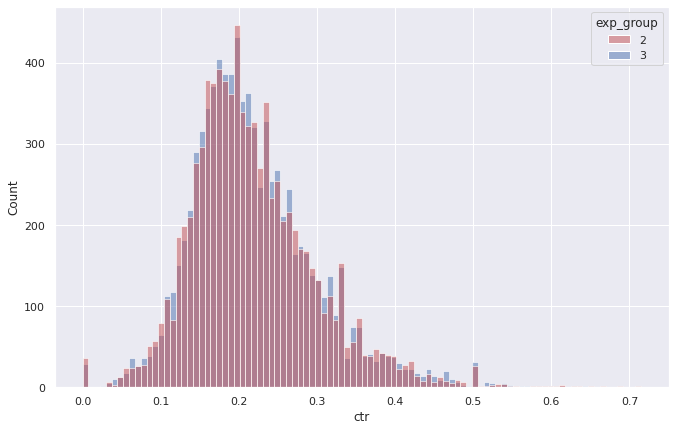

In [5]:
sns.set(rc={'figure.figsize':(11,7)})

groups = sns.histplot(data = aa_data, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

На графике мы видим, что данные распределились примерно одинаково.

Генерируем 10000 подвыборок без повторения в 500 юзеров из 2 и 3 экспериментальной группы. 
Попарно проводим сравнение этих подвыборок t-testом.

In [6]:
group_2 = aa_data[aa_data.exp_group == 2]
group_3 = aa_data[aa_data.exp_group == 3]

p_values = []
for _ in range(10000):
    gp2 = group_2.ctr.sample(500, replace=False)
    gp3 = group_3.ctr.sample(500, replace=False)
    p_value = stats.ttest_ind(gp2, gp3, equal_var=False)[1]
    p_values.append(p_value)
p_values = pd.Series(p_values)

Построим гистограмму распределения получившихся 10000 p-values:

<AxesSubplot:ylabel='Count'>

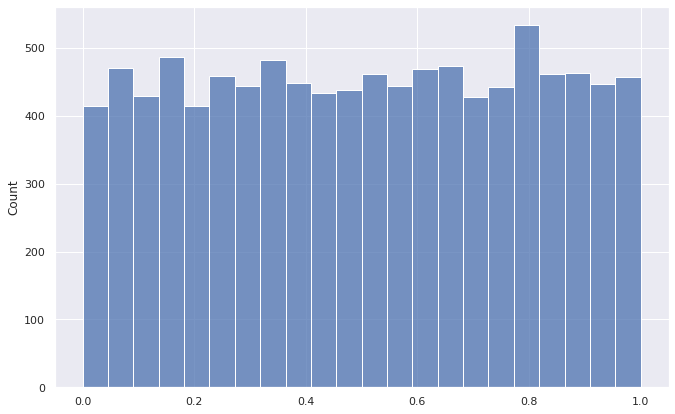

In [7]:
sns.histplot(p_values)

Найдём p_values:

In [8]:
false_positive_percent = p_values[p_values <= 0.05].count() / p_values.count()

print('p_values  = {}%'.format(round(false_positive_percent * 100, 2)))

p_values  = 4.57%


## Вывод
P-values оказалось менее 5%, что свидетельствует о том, что наша система сплитования работает корректно и АА-тест пройден успешно.